# RasProcess: Automated Stored Map Generation

This notebook demonstrates how to use the `RasProcess` class to generate stored maps (raster outputs) from HEC-RAS results using the RasProcess.exe command-line interface.

## Overview

The `RasProcess` class provides a programmatic interface to RasProcess.exe, an undocumented CLI tool bundled with HEC-RAS that enables headless generation of stored maps without opening the RASMapper GUI.

## Key Features

- Generate WSE, Depth, Velocity, Froude, Shear Stress, D*V, and D*V² rasters
- Support for Max/Min profiles or specific timesteps
- Automatic georeferencing fix for output TIFs
- Batch processing of all plans in a project

## Requirements

- HEC-RAS 6.x installed (RasProcess.exe must be available)
- Computed HEC-RAS plan with HDF results
- rasterio (optional, for georeferencing fix)

#!pip install --upgrade ras-commander

# Import the ras-commander package
from ras_commander import *

In [1]:
##### Optional Code Cell For Development/Testing Mode (Local Copy)
##### Uncomment and run this cell instead of the pip cell above

# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print("Loading ras-commander from local dev copy")
from ras_commander import *

Loading ras-commander from local dev copy


In [2]:
# Additional imports for visualization
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Initialize Project

We'll use the Bald Eagle Creek example project which has multiple 2D plans with computed results.

In [3]:
# Extract the Bald Eagle Creek project
project_path = Path("./example_projects/BaldEagleCrkMulti2D").resolve()

if not project_path.exists():
    project_path = RasExamples.extract_project("BaldEagleCrkMulti2D")

# Initialize the project
init_ras_project(project_path, "6.6")

print(f"Project: {ras.project_name}")
print(f"Folder: {ras.project_folder}")

2025-12-09 23:13:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


Project: BaldEagleDamBrk
Folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D


In [4]:
# View available plans
print("Available Plans:")
print("=" * 60)

for _, row in ras.plan_df.iterrows():
    plan_num = row['plan_number']
    title = row.get('Plan Title', 'Unknown')
    hdf_path = ras.project_folder / f"{ras.project_name}.p{plan_num}.hdf"
    has_results = "Yes" if hdf_path.exists() else "No"
    print(f"  Plan {plan_num}: {title} (HDF: {has_results})")

Available Plans:
  Plan 13: PMF with Multi 2D Areas (HDF: No)
  Plan 15: 1d-2D Dambreak Refined Grid (HDF: No)
  Plan 17: 2D to 1D No Dam (HDF: No)
  Plan 18: 2D to 2D Run (HDF: No)
  Plan 19: SA to 2D Dam Break Run (HDF: No)
  Plan 03: Single 2D Area - Internal Dam Structure (HDF: No)
  Plan 04: SA to 2D Area Conn - 2D Levee Structure (HDF: No)
  Plan 02: SA to Detailed 2D Breach (HDF: No)
  Plan 01: SA to Detailed 2D Breach FEQ (HDF: Yes)
  Plan 05: Single 2D area with Bridges FEQ (HDF: No)
  Plan 06: Gridded Precip - Infiltration (HDF: Yes)
  Plan 07: AORC Storm Apr 17, 2020 (HDF: No)


## Step 2: Find RasProcess.exe

Before generating maps, let's verify RasProcess.exe is available.

In [5]:
# Find RasProcess.exe
rasprocess_path = RasProcess.find_rasprocess("6.6")

if rasprocess_path:
    print(f"Found RasProcess.exe: {rasprocess_path}")
else:
    print("ERROR: RasProcess.exe not found. Check HEC-RAS installation.")

Found RasProcess.exe: C:\Program Files (x86)\HEC\HEC-RAS\6.6\RasProcess.exe


## Step 3: Generate Individual Maps for Plan 06

The `store_maps()` function generates stored maps for a single plan. By default, it generates WSE, Depth, and Velocity maps for the Max profile.

### Available Map Types

| Parameter | Map Type | Default |
|-----------|----------|--------|
| `wse` | Water Surface Elevation | True |
| `depth` | Water Depth | True |
| `velocity` | Velocity Magnitude | True |
| `froude` | Froude Number | False |
| `shear_stress` | Shear Stress | False |
| `depth_x_velocity` | D*V (Hazard) | False |
| `depth_x_velocity_sq` | D*V² (Impact) | False |

In [6]:
RasCmdr.compute_plan(6)

2025-12-09 23:13:43 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D
2025-12-09 23:13:43 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:
2025-12-09 23:13:43 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06"
2025-12-09 23:18:26 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 6
2025-12-09 23:18:26 - ras_commander.RasCmdr - INFO - Total run time for plan 6: 282.13 seconds


True

In [7]:
# Generate default maps (WSE, Depth, Velocity) for plan 06
print("Generating stored maps for Plan 06...")
print("This may take a minute depending on model size.")
print()

results = RasProcess.store_maps(
    plan_number="06",
    profile="Max",
    wse=True,
    depth=True,
    velocity=True,
    fix_georef=True,
    ras_version="6.6"
)

print("\nGenerated files:")
for map_type, files in results.items():
    print(f"  {map_type}: {len(files)} file(s)")
    for f in files:
        print(f"    - {f.name}")

2025-12-09 23:18:26 - ras_commander.RasProcess - INFO - Created plan layer 'Grid Precip Infiltration' in rasmap for BaldEagleDamBrk.p06.hdf
2025-12-09 23:18:26 - ras_commander.RasProcess - INFO - Running StoreAllMaps for plan 06...


Generating stored maps for Plan 06...
This may take a minute depending on model size.



2025-12-09 23:18:34 - ras_commander.RasProcess - WARNING - StoreAllMaps stderr: Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations

2025-12-09 23:18:34 - ras_commander.RasProcess - INFO - Generated 1 wse TIF(s)
2025-12-09 23:18:34 - ras_commander.RasProcess - INFO - Generated 1 depth TIF(s)
2025-12-09 23:18:34 - ras_commander.RasProcess - INFO - Generated 1 velocity TIF(s)
2025-12-09 23:18:35 - ras_commander.RasProcess - INFO - Fixed georeferencing: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Grid Prec


Generated files:
  wse: 1 file(s)
    - WSE (Max).Terrain50.dtm_20ft.tif
  depth: 1 file(s)
    - Depth (Max).Terrain50.dtm_20ft.tif
  velocity: 1 file(s)
    - Velocity (Max).Terrain50.dtm_20ft.tif


In [8]:
# Generate additional map types
print("Generating Froude and D*V maps...")

results_extra = RasProcess.store_maps(
    plan_number="06",
    profile="Max",
    wse=False,
    depth=False,
    velocity=False,
    froude=True,
    depth_x_velocity=True,
    fix_georef=True,
    ras_version="6.6"
)

print("\nGenerated files:")
for map_type, files in results_extra.items():
    print(f"  {map_type}: {len(files)} file(s)")
    for f in files:
        print(f"    - {f.name}")

2025-12-09 23:18:36 - ras_commander.RasProcess - INFO - Created plan layer 'Grid Precip Infiltration' in rasmap for BaldEagleDamBrk.p06.hdf
2025-12-09 23:18:36 - ras_commander.RasProcess - INFO - Running StoreAllMaps for plan 06...


Generating Froude and D*V maps...


2025-12-09 23:22:16 - ras_commander.RasProcess - WARNING - StoreAllMaps stderr: Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations

2025-12-09 23:22:16 - ras_commander.RasProcess - INFO - Generated 1 froude TIF(s)
2025-12-09 23:22:16 - ras_commander.RasProcess - INFO - Generated 1 depth_x_velocity TIF(s)
2025-12-09 23:22:17 - ras_commander.RasProcess - INFO - Fixed georeferencing: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Grid Precip Infiltration\Froude (Max).Terrain50.dtm_20ft.tif
2025-12-09 23:22:17 - ras_commander.RasProcess - INFO - Fixed georeferencing: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Grid Precip Infiltration\D _ V (Max).Terrain50.d


Generated files:
  froude: 1 file(s)
    - Froude (Max).Terrain50.dtm_20ft.tif
  depth_x_velocity: 1 file(s)
    - D _ V (Max).Terrain50.dtm_20ft.tif


## Step 4: Get Available Timestamps

For time-series analysis, you can generate maps for specific timesteps instead of Max/Min.

In [9]:
# Get available timestamps for plan 06
timestamps = RasProcess.get_plan_timestamps("06")

print(f"Available timestamps ({len(timestamps)} total):")
print(f"  First: {timestamps[0]}")
print(f"  Last:  {timestamps[-1]}")
print()
print("Sample timestamps:")
for ts in timestamps[::len(timestamps)//5][:5]:
    print(f"  {ts}")

2025-12-09 23:22:17 - ras_commander.hdf.HdfPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-12-09 23:22:17 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf


Available timestamps (721 total):
  First: 09SEP2018 00:00:00
  Last:  14SEP2018 00:00:00

Sample timestamps:
  09SEP2018 00:00:00
  10SEP2018 00:00:00
  11SEP2018 00:00:00
  12SEP2018 00:00:00
  13SEP2018 00:00:00


In [10]:
# Generate map for a specific timestep
# Note: Use exact timestamp format from get_plan_timestamps()

if len(timestamps) > 10:
    target_timestamp = timestamps[10]  # Get 10th timestep
    
    print(f"Generating WSE map for timestep: {target_timestamp}")
    
    results_ts = RasProcess.store_maps(
        plan_number="06",
        profile=target_timestamp,
        wse=True,
        depth=False,
        velocity=False,
        fix_georef=True,
        ras_version="6.6"
    )
    
    print("\nGenerated:")
    for map_type, files in results_ts.items():
        for f in files:
            print(f"  {f.name}")

2025-12-09 23:22:17 - ras_commander.hdf.HdfPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-12-09 23:22:17 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-12-09 23:22:17 - ras_commander.RasProcess - INFO - Created plan layer 'Grid Precip Infiltration' in rasmap for BaldEagleDamBrk.p06.hdf
2025-12-09 23:22:17 - ras_commander.RasProcess - INFO - Running StoreAllMaps for plan 06...


Generating WSE map for timestep: 09SEP2018 01:40:00


2025-12-09 23:22:21 - ras_commander.RasProcess - WARNING - StoreAllMaps stderr: Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations

2025-12-09 23:22:21 - ras_commander.RasProcess - INFO - Generated 1 wse TIF(s)
2025-12-09 23:22:22 - ras_commander.RasProcess - INFO - Fixed georeferencing: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\Grid Precip Infiltration\WSE (09SEP2018 01 40 00).Terrain50.dtm_20ft.tif



Generated:
  WSE (09SEP2018 01 40 00).Terrain50.dtm_20ft.tif


## Step 5: Visualize Generated Maps

Let's visualize the generated raster files.

In [11]:
def plot_raster(raster_path, title, cmap='viridis'):
    """Plot a raster file with automatic extent calculation."""
    with rasterio.open(raster_path) as src:
        data = src.read(1, masked=True)
        
        # Get valid data bounds
        valid = ~np.ma.getmaskarray(data)
        if valid.any():
            rows, cols = np.where(valid)
            row_min, row_max = rows.min(), rows.max()
            col_min, col_max = cols.min(), cols.max()
            
            # Transform to coordinates
            tl = src.transform * (col_min, row_min)
            br = src.transform * (col_max + 1, row_max + 1)
            
            # Add 10% padding
            xpad = (br[0] - tl[0]) * 0.1
            ypad = (tl[1] - br[1]) * 0.1
            
            extent = [tl[0] - xpad, br[0] + xpad, br[1] - ypad, tl[1] + ypad]
        else:
            extent = [src.bounds.left, src.bounds.right, 
                     src.bounds.bottom, src.bounds.top]
        
        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(
            data, cmap=cmap,
            extent=[src.bounds.left, src.bounds.right, 
                   src.bounds.bottom, src.bounds.top],
            origin='upper'
        )
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_xlabel('Easting (ft)')
        ax.set_ylabel('Northing (ft)')
        ax.set_title(title, fontsize=14, fontweight='bold')
        plt.colorbar(im, ax=ax, shrink=0.8)
        plt.tight_layout()
        plt.show()
        
        # Print metadata
        print(f"CRS: {src.crs}")
        print(f"Resolution: {src.res}")
        print(f"Data range: {data.min():.2f} - {data.max():.2f}")

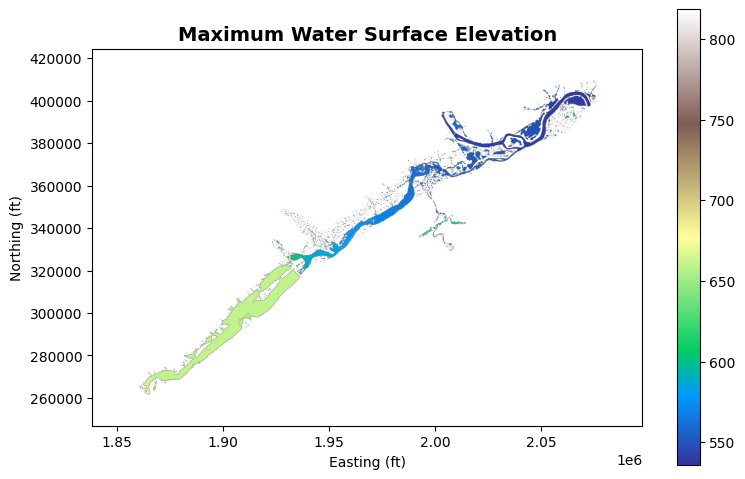

CRS: EPSG:2271
Resolution: (36.504512049933, 36.504512049933)
Data range: 535.59 - 818.48


In [12]:
# Plot WSE if available
if 'wse' in results and results['wse']:
    plot_raster(results['wse'][0], 'Maximum Water Surface Elevation', 'terrain')

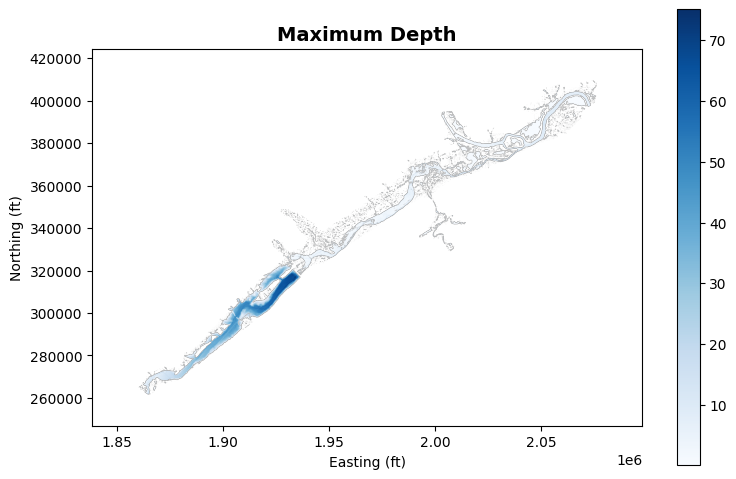

CRS: EPSG:2271
Resolution: (36.504512049933, 36.504512049933)
Data range: 0.00 - 75.10


In [13]:
# Plot Depth if available
if 'depth' in results and results['depth']:
    plot_raster(results['depth'][0], 'Maximum Depth', 'Blues')

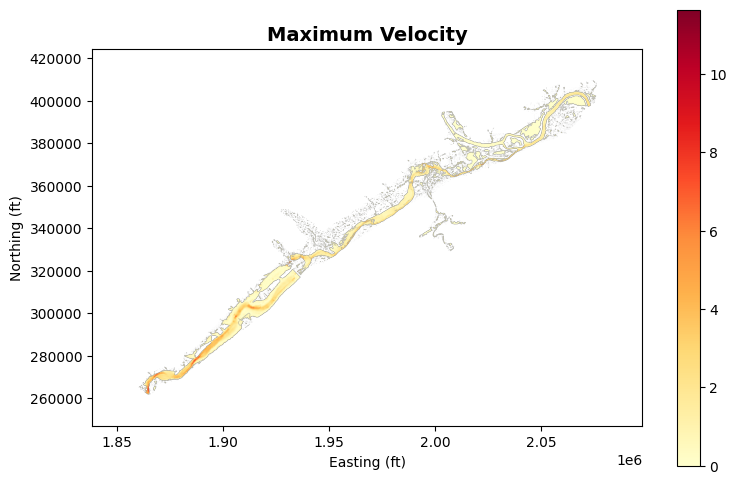

CRS: EPSG:2271
Resolution: (36.504512049933, 36.504512049933)
Data range: 0.00 - 11.65


In [14]:
# Plot Velocity if available
if 'velocity' in results and results['velocity']:
    plot_raster(results['velocity'][0], 'Maximum Velocity', 'YlOrRd')

## Step 6: Bulk Map Generation for All Plans

The `store_all_maps()` function processes all plans with HDF results in a single call.

In [15]:
# Generate maps for all plans with HDF results
print("Generating stored maps for ALL plans...")
print("This may take several minutes.")
print()

all_results = RasProcess.store_all_maps(
    profile="Max",
    wse=True,
    depth=True,
    velocity=True,
    froude=False,  # Skip extra maps for speed
    fix_georef=True,
    ras_version="6.6"
)

print("\n" + "=" * 60)
print("Results Summary")
print("=" * 60)

for plan_num, files in all_results.items():
    if 'error' in files:
        print(f"\nPlan {plan_num}: ERROR - {files['error']}")
    else:
        total = sum(len(f) for f in files.values())
        print(f"\nPlan {plan_num}: {total} files generated")
        for map_type, file_list in files.items():
            for f in file_list:
                print(f"  - {f.name}")

2025-12-09 23:22:36 - ras_commander.RasProcess - INFO - Created plan layer 'SA-2D Det FEQ' in rasmap for BaldEagleDamBrk.p01.hdf
2025-12-09 23:22:36 - ras_commander.RasProcess - INFO - Running StoreAllMaps for plan 01...


Generating stored maps for ALL plans...
This may take several minutes.



2025-12-09 23:22:44 - ras_commander.RasProcess - WARNING - StoreAllMaps stderr: Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations

2025-12-09 23:22:44 - ras_commander.RasProcess - INFO - Generated 1 wse TIF(s)
2025-12-09 23:22:44 - ras_commander.RasProcess - INFO - Generated 1 depth TIF(s)
2025-12-09 23:22:44 - ras_commander.RasProcess - INFO - Generated 1 velocity TIF(s)
2025-12-09 23:22:45 - ras_commander.RasProcess - INFO - Fixed georeferencing: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\SA-2D Det


Results Summary

Plan 01: 3 files generated
  - WSE (Max).Terrain50.dtm_20ft.tif
  - Depth (Max).Terrain50.dtm_20ft.tif
  - Velocity (Max).Terrain50.dtm_20ft.tif

Plan 06: 3 files generated
  - WSE (Max).Terrain50.dtm_20ft.tif
  - Depth (Max).Terrain50.dtm_20ft.tif
  - Velocity (Max).Terrain50.dtm_20ft.tif


## Summary

This notebook demonstrated:

1. **Finding RasProcess.exe** - Automatically locate the CLI tool
2. **Individual Map Generation** - Generate specific map types for a single plan
3. **Timestep Selection** - Generate maps for Max/Min or specific timestamps
4. **Visualization** - Load and display generated rasters
5. **Bulk Processing** - Generate maps for all plans at once


### Key Functions

| Function | Description |
|----------|-------------|
| `RasProcess.find_rasprocess()` | Find RasProcess.exe installation |
| `RasProcess.get_plan_timestamps()` | Get available output times |
| `RasProcess.store_maps()` | Generate maps for a single plan |
| `RasProcess.store_all_maps()` | Batch process all plans |
| `RasProcess.run_command()` | Execute raw XML commands |

### Notes

- Output files are written to the plan's result layer folder (determined by the `.rasmap` file)
- The `fix_georef=True` option applies CRS from the project's projection file
- StoreAllMaps command is used internally (more reliable than StoreMap)
- GDAL warning about NoDataValue is cosmetic and can be ignored